# 3D/Hybrid intracellular tutorial

## 3D/Hybrid intracellular tutorial

We have expanded the capabilities of the NEURON reaction diffusion module to support pure 3D and 1D/3D hybrid intracellular simulations. This tutorial provides an overview of how to set up a simple travelling wave in both cases.

### Download Files

Download the following .ses file and save it in your working directory:

In [1]:
!wget -O c91662.ses "https://senselab.med.yale.edu/modeldb/getModelFile?model=87284&AttrID=23&s=yes&file=/%2fCA1_abeta%2fc91662.ses"

--2023-07-21 05:16:54--  https://senselab.med.yale.edu/modeldb/getModelFile?model=87284&AttrID=23&s=yes&file=/%2fCA1_abeta%2fc91662.ses
Resolving senselab.med.yale.edu (senselab.med.yale.edu)... 128.36.64.81
Connecting to senselab.med.yale.edu (senselab.med.yale.edu)|128.36.64.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89559 (87K) [text/plain]
Saving to: ‘c91662.ses’

c91662.ses          100%[===================>]  87.46K  41.0KB/s    in 2.1s    

2023-07-21 05:17:00 (41.0 KB/s) - ‘c91662.ses’ saved [89559/89559]



This is a saved session file of a loaded morphology from <a href=https://neuromorpho.org/>NeuroMorpho.org</a>. If you would like to see how to load the morphology from an .swc file, see <a href=https://nrn.readthedocs.io/en/latest/rxd-tutorials/extracellular.html/>this example</a>

### Getting Started

To run 3D reaction diffusion simulations, begin by import the rxd module.



In [2]:
from neuron import h, rxd

Next, we load the .ses file to access the cell we will perform our simulation with



In [3]:
h.load_file("stdrun.hoc")
h.load_file("c91662.ses")

1.0

We tell NEURON that we want all sections to be in 3 dimensions.

In [4]:
rxd.set_solve_type(h.allsec(), dimension=3)

3D Intracellular reaction diffusion supports multithreaded parallelization



In [5]:
rxd.nthread(4)

4

Now we can define our reaction diffusion equations. We use the same Who, Where, How interface as the same Where/Who/How scheme as with 1D and extracellular reaction diffusion. Here we define a species ca on all sections of our cell with an initial concentration of 1 in a non-soma section and a concentration of 0 everywhere else.

In [6]:
r = rxd.Region(h.allsec(), nrn_region="i", dx=0.17)
ca = rxd.Species(
    r,
    d=0.25,
    name="ca",
    charge=2,
    initial=lambda node: 1 if node.sec in [h.apic[8]] else 0,
)
bistable_reaction = rxd.Rate(ca, -ca * (1 - ca) * (0.01 - ca))
h.dt = 0.1  # We choose dt = 0.1 here because the ratio of d * dt / dx**2 must be less than 1
h.finitialize(-65)

1.0

We are now ready to run the simulation, but first we will write a function to make a contour plot on a 2D projection of the cell to illustrate the wave's propagation. We are hardcoding the x and y limits to make the plot appear larger in Jupyter. If you are not running in Jupyter, you can comment out the lines:

```python
plt.axis('auto')
plt.gca().set_xlim(750,1750)
plt.gca().set_ylim(1200,2900)
```

and uncomment the <tt>plt.axis('equal')<tt> line and zoom in on the areas of interest.

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from neuron.rxd.node import Node3D


def plot_contours(species):
    r = species.nodes[0].region
    xz = np.empty((max(r._xs) + 1, max(r._zs) + 1))
    xz.fill(np.nan)

    def replace_nans(a, b):
        if np.isnan(a):
            return b
        return max(a, b)

    for node in species.nodes:
        if isinstance(node, Node3D):
            xz[node._i, node._k] = replace_nans(xz[node._i, node._k], node.value)
    xs, ys = np.meshgrid(range(xz.shape[1]), range(xz.shape[0]))
    plt.contour(xs, ys, np.nan_to_num(xz), [0.5], colors="k", linewidths=0.5)
    plt.axis("auto")
    plt.gca().set_xlim(750, 1750)
    plt.gca().set_ylim(1200, 2900)
    # plt.axis('equal')
    plt.axis("off")

We will draw a contour every 50 ms

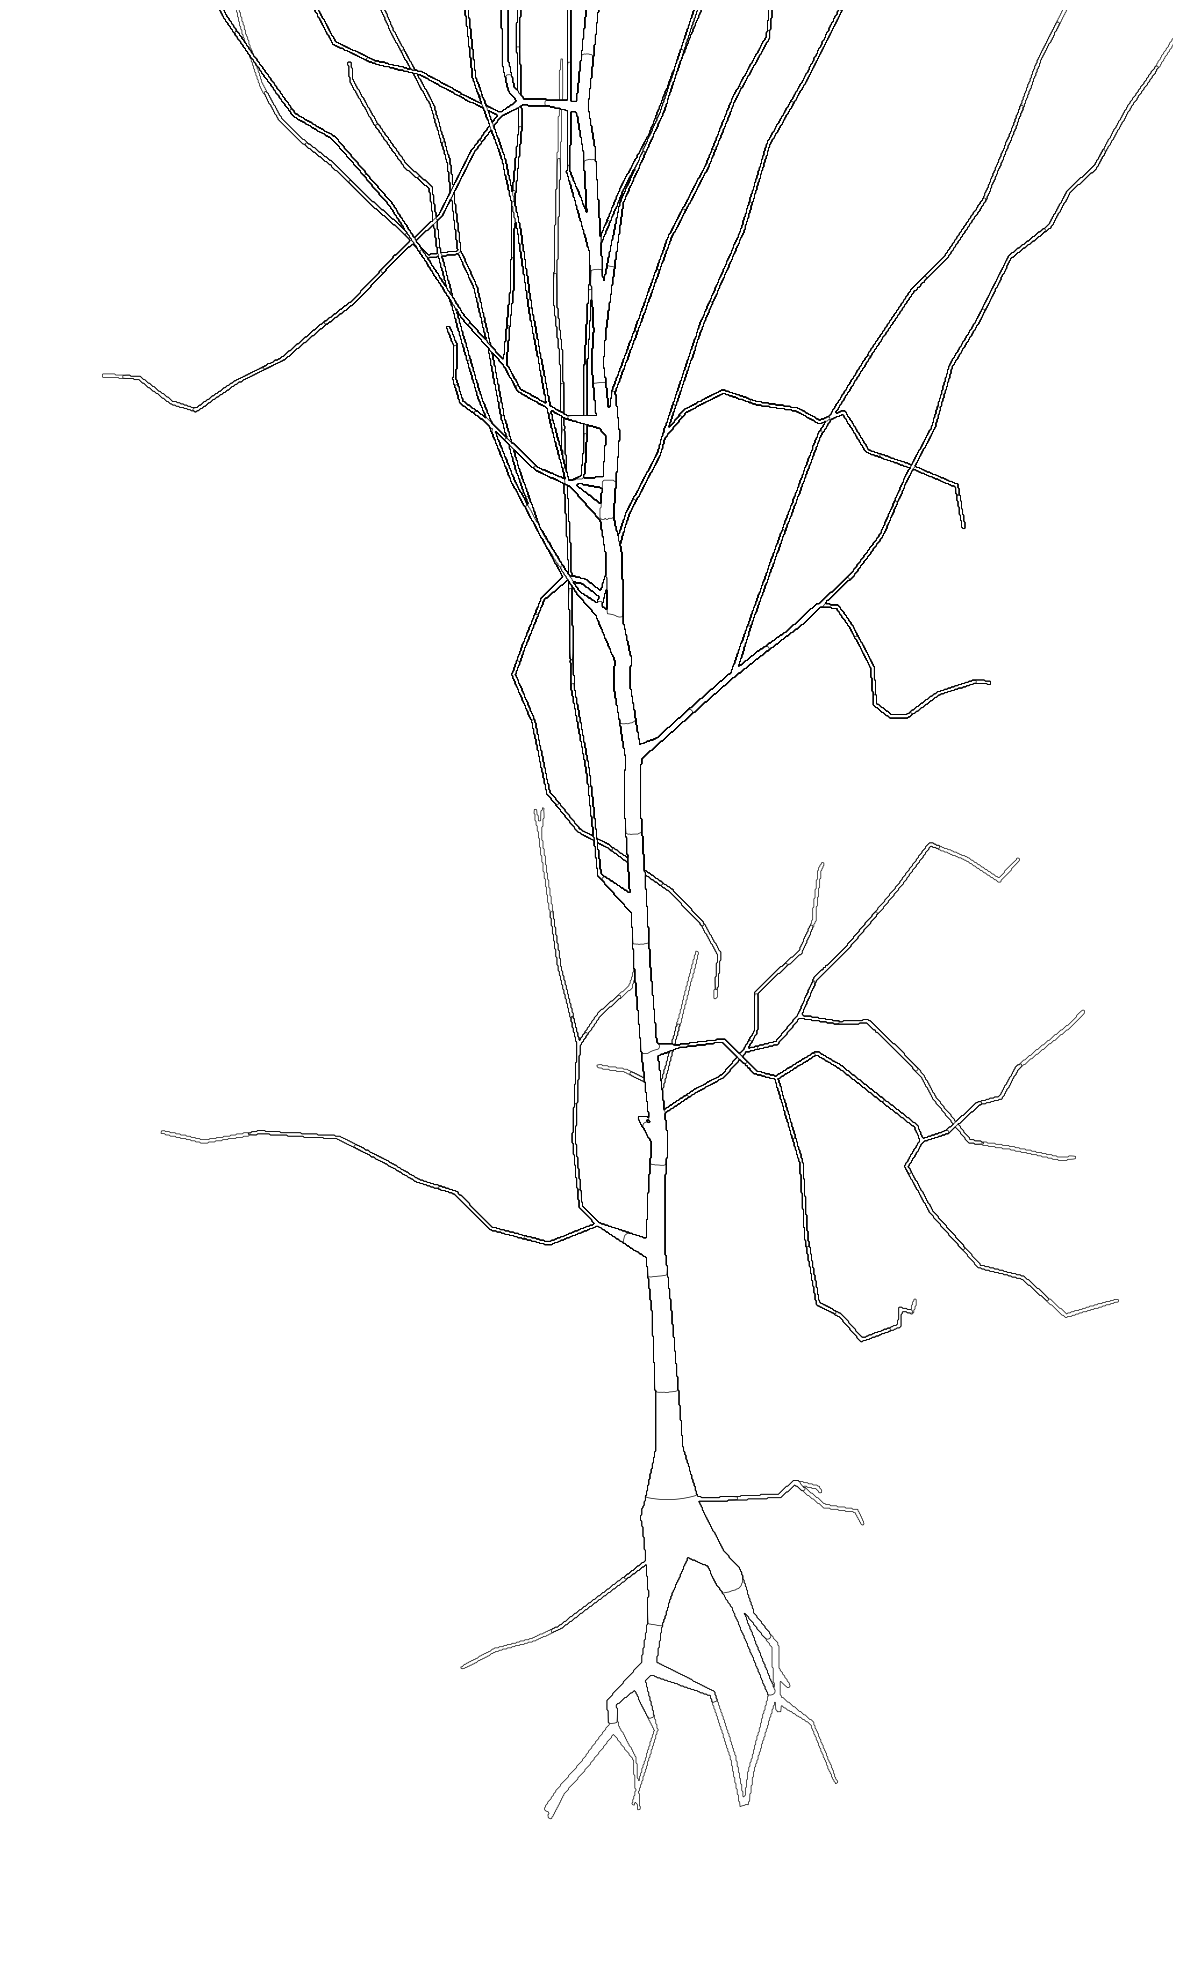

In [8]:
plt.figure(figsize=(15, 25.5))
for i in range(13):
    h.continuerun(i * 50)
    plot_contours(ca)
plt.show()

## Hybrid Example

We can perfrom the same simulation but instead of simulating all the sections in 3D, we can tell NEURON to only make the soma and surrounding areas in 3D while the rest of the cell will be simulated in 1D. Simulating the majority of the cell in 1D vastly decreases the runtime while maintaining the accuracy of the simulation.

We begin again by importing rxd and loading the relevant files, and setting the number of threads

In [1]:
from neuron import h, rxd

h.load_file("stdrun.hoc")
h.load_file("c91662.ses")
rxd.nthread(4)

4

Now we have to tell NEURON which sections we want to make 3D vs 1D. The defualt behavior is to do everything in 1D. However, we can send in a section or list of sections to make 3D.

Here we choose the soma, the first two sections of apic, and all the basal dendrites to be in 3D



In [2]:
secs3d = [h.soma, h.apic[0], h.apic[1]] + [
    dend for dend in h.allsec() if "basal" in str(dend)
]
rxd.set_solve_type(secs3d, dimension=3)

# Set nseg for our 1D sections
secs1d = [sec for sec in h.allsec() if sec not in secs3d]
for sec in secs1d:
    sec.nseg = 11

We will use the same rxd equations and a slightly modified plot_contours function for the 3D portion. As before, we are hardcoding the x and y limits to make the plot more visible in Jupyter. We also need to plot the wave in the 1D portion of the cell. For this we will use a RangeVarPlot

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from neuron.rxd.node import Node3D


def plot_contours(species):
    r = species.nodes[0].region
    xz = np.empty((max(r._xs) + 1, max(r._zs) + 1))
    xz.fill(np.nan)

    def replace_nans(a, b):
        if np.isnan(a):
            return b
        return max(a, b)

    for node in ca.nodes:
        if isinstance(node, Node3D):
            xz[node._i, node._k] = replace_nans(xz[node._i, node._k], node.value)
    xs, ys = np.meshgrid(range(xz.shape[1]), range(xz.shape[0]))
    plt.contour(xs, ys, np.nan_to_num(xz), [0.5], colors="k", linewidths=0.5)
    plt.axis("auto")
    plt.gca().set_xlim(600, 1100)
    plt.gca().set_ylim(1000, 1920)
    # plt.axis('equal')
    plt.axis("off")

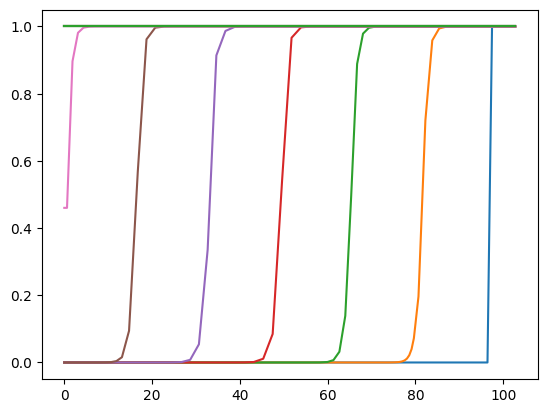

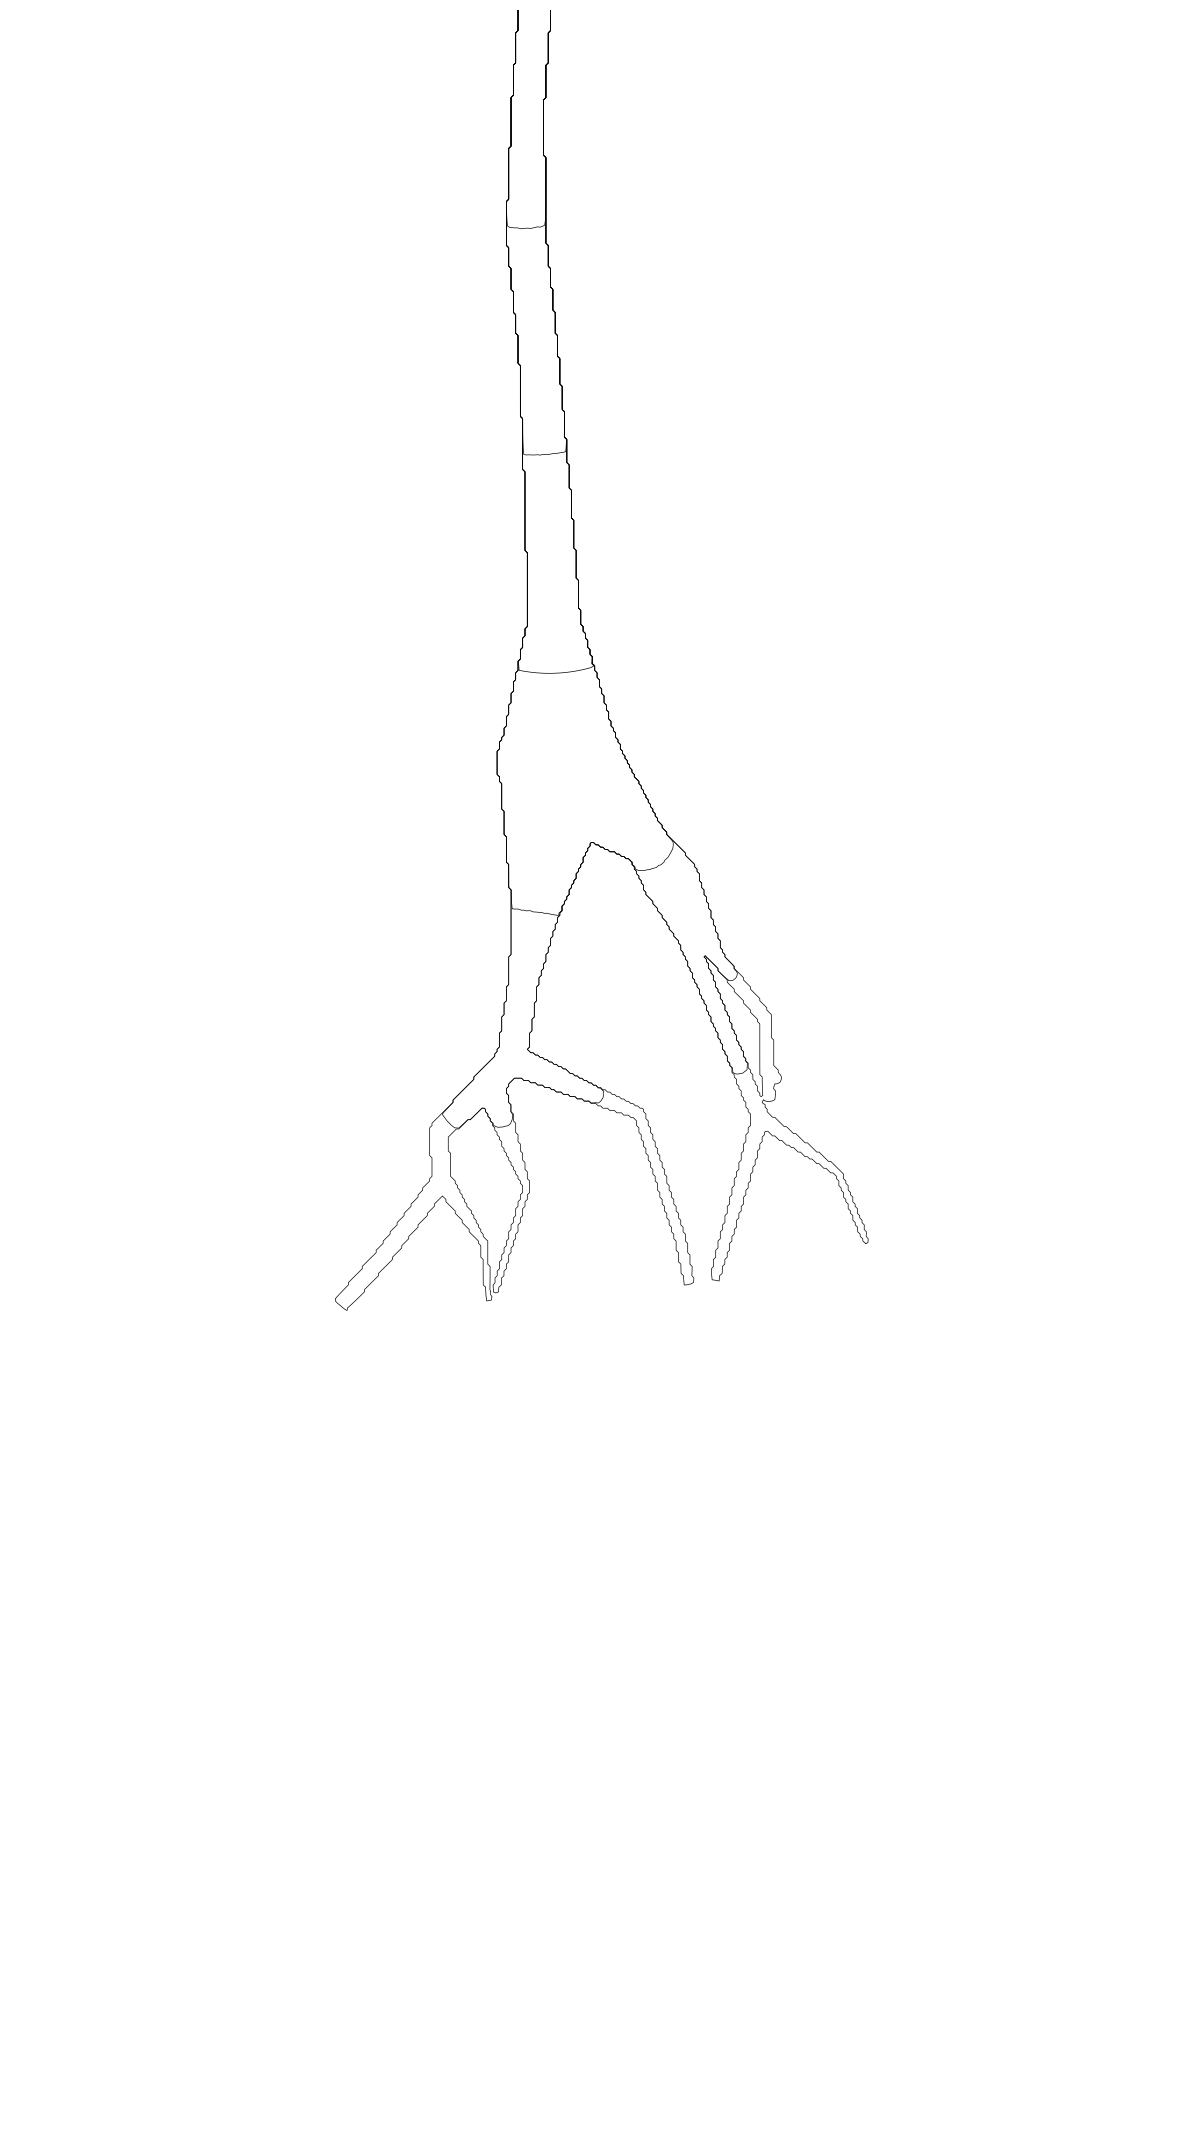

In [4]:
r = rxd.Region(h.allsec(), nrn_region="i", dx=0.17)
ca = rxd.Species(
    r,
    d=0.25,
    name="ca",
    charge=2,
    initial=lambda node: 1 if node.sec in [h.apic[8]] else 0,
)
bistable_reaction = rxd.Rate(ca, -ca * (1 - ca) * (0.01 - ca))
h.dt = 0.1  # We choose dt = 0.1 here because the ratio of d * dt / dx**2 must be less than 1
h.finitialize(-65)

# We make the RangeVarPlot range from the section we initialized to be 1 through the 1D section that touches our first 3D section
rvp = h.RangeVarPlot("cai", h.apic[2](0), h.apic[8](1))

for i in range(13):
    h.continuerun(i * 50)
    plt.figure(1)
    rvp.plot(plt)
    plt.figure(2, figsize=(15, 27.6))
    if max(ca.nodes(h.apic[1]).concentration) > 0.5:
        plot_contours(ca)
plt.show()